In [1]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

sys.path.insert(
    2,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/pinn"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

In [2]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "damping"
VARYING_PARAM_NOTATION: str = "d"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Specify the range of parameter values
PARAM_LIST: list[float] = [0.00015, 0.0015, 0.015, 0.15, 1.5]#[0.00025, 0.0025, 0.025, 0.25, 2.5]
# DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = False

# Define flag whether or not to use R3 algorithm
R3: bool = True

In [3]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
# DEVICE: str = torch.device("mps" if torch.backends.mps.is_available else "cpu")
DEVICE: str = "cpu"

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float32
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
EPOCHS: int = 5_000
N_C: int = 1_000  # Number of collocation points

# PINN soft regularisation weights in the loss function
PHYSICS_WEIGHT: float = 1.0
IC_WEIGHT: float = 1.0

# Specify activation function
ACTIVATION: str = "tanh"

In [4]:
def R3_algorithm(collocation_set: torch.Tensor, model: Callable, **kwargs) -> torch.Tensor:
    assert collocation_set.requires_grad is True

    residual_array = []

    model.eval()

    for t in collocation_set:
        t_fresh = t.clone().detach().requires_grad_(True)  # New leaf node with grad

        phase_angle_pred = model.forward(data=t_fresh)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=t_fresh,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=t_fresh,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=kwargs["DAMPING"],
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False)
        residual_array.append(torch.abs(residual).detach())
        
    residual_tensor = torch.stack(residual_array)
    threshold = torch.mean(residual_tensor)

    # Retain points above threshold
    retained = collocation_set[residual_tensor > threshold]
    retained = retained.clone().detach().requires_grad_(True) 

    # Resample new ones
    n_to_sample = N_C - retained.shape[0]
    new_samples = (T0 - FINALTIME) * torch.rand((n_to_sample, 1), device=collocation_set.device, requires_grad=True) + FINALTIME

    collocation_next_epoch = torch.cat([retained, new_samples], dim=0)
    collocation_next_epoch = collocation_next_epoch.clone().detach().requires_grad_(True)  # Final safety

    assert collocation_next_epoch.shape == (N_C, 1)
    assert collocation_next_epoch.requires_grad is True
    
    model.train()
    return collocation_next_epoch


# Obtain collocation points sampled of size N_C either via uniform sampling (R3) or LHS
if R3:
    collocation_points: torch.Tensor =\
        (T0 - FINALTIME) * torch.rand(size=(N_C, 1), requires_grad=True).to(device=DEVICE) + FINALTIME
else:
    LHC = qmc.LatinHypercube(d=1)
    collocation_points = LHC.random(n=N_C)
    collocation_points = qmc.scale(
        collocation_points, T0, FINALTIME
    ).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

    collocation_points: torch.Tensor = torch.tensor(
        data=collocation_points[:, None].astype(np.float32), requires_grad=True
    ).to(device=DEVICE)

assert collocation_points.shape == (N_C, 1)

## This cell contains a parameter which must be changed

In [5]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.3

for param in PARAM_LIST:

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    # solution, noisy_solution, numerical_times = swing_ODEs_solver(
    #     initial_time=0,
    #     initial_state=INITIAL_STATE.detach().numpy(),
    #     final_time=20.0,
    #     timestep=0.1,
    #     inertia=0.25,
    #     damping=param,
    #     mechanical_power=0.13,
    #     voltage_magnitude=1.0,
    #     include_controllers=False,
    #     voltages=np.array([1.0]),
    #     phase_angles=np.array([0.0]),
    #     susceptances=np.array([0.2]),
    #     file_name="test_run",
    #     save_output_to_file=False,
    #     controller_proportional=0.05,
    #     controller_integral=0.1
    # )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)
rand_index.shape

(61,)

In [6]:
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [7]:
# Define subspace mesh
LB: int = -5
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-6
assert torch.norm(input=direction_vec_2) - 1 < 1e-6

In [8]:
globals()['SwingEquationInputs']

loss_functions.SwingEquationInputs

In [9]:
# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Collect residual losses across each parameter value
residual_losses_per_param = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch = []

# Collect summary statistics of the distribution of residual values per epoch per parameter
skewness_per_param = []
kurtosis_per_param = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    # Define list to collect total training loss every epoch
    training_loss = []

    # Define list to collect residual loss every epoch
    residual_loss = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss = []

    # Define two lists to collect skewness and kurtosis values per epoch of the residual loss distributions
    kurtosis_list = []
    skewness_list = []

    # Perform the training loop using full-batch training
    for epoch in tqdm(range(EPOCHS)):

        # Obtain PINN rediction at current state for test set and evaluate performance
        ground_truth_phase_angle = numerical_solutions_exact_tensor[index, 0, :]
        ground_truth_angular_frequency = numerical_solutions_exact_tensor[index, 1, :]
        
        phase_angle_pred_test = pinn.forward(data=times_tensor, initial_state=INITIAL_STATE)

        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=True,
            retain_graph=True
        )[0]

        pred_vector = torch.stack(tensors=(phase_angle_pred_test, angular_frequency_pred_test), dim=0).squeeze()
        label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = pinn.forward(
            data=collocation_points, initial_state=INITIAL_STATE
        )

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        loss_func = loss_closure(
            swing_inputs=swing_inputs,
            physics_weight=PHYSICS_WEIGHT,
            IC_weight=IC_WEIGHT,
            model=pinn,
            initial_state=INITIAL_STATE,
            device=DEVICE,
            include_controllers=CONTROLLERS,
        ) 

        # Obtain residual loss (no backprop)
        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False).item()
        residual_loss.append(residual)

        # Compute summary statistics of the distribution of residuals at the given epoch
        skewness_val = skew(a=np.array(residual_loss))
        kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

        skewness_list.append(skewness_val)
        kurtosis_list.append(kurtosis_val)

        # Obtain the total loss and backpropogate on that value
        loss = loss_func(inputs=None, targets=None)
        training_loss.append(loss.item())

        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step(metrics=loss)

        if epoch % 100 == 0:
        # Use the R3 algorithm to update the global collocation set for the next epoch
            collocation_points = R3_algorithm(collocation_set=collocation_points, model=pinn, DAMPING=DAMPING)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")
    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses_per_param.append(training_loss)
    residual_losses_per_param.append(residual_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    skewness_per_param.append(skewness_list)
    kurtosis_per_param.append(kurtosis_list)

Param value 1
----------------------



  1%|          | 31/5000 [00:00<01:02, 79.97it/s]

Training loss: 0.02455773577094078


  3%|▎         | 150/5000 [00:01<00:37, 130.24it/s]

Training loss: 0.0006130957044661045


  5%|▍         | 237/5000 [00:01<00:36, 131.77it/s]

Training loss: 0.0006000951980240643


  7%|▋         | 355/5000 [00:02<00:33, 139.18it/s]

Training loss: 0.0003777398669626564


  9%|▉         | 448/5000 [00:03<00:33, 137.61it/s]

Training loss: 0.00045975722605362535


 11%|█         | 536/5000 [00:04<00:33, 134.52it/s]

Training loss: 0.00048566990881226957


 13%|█▎        | 652/5000 [00:04<00:31, 137.49it/s]

Training loss: 0.0005579903954640031


 15%|█▍        | 736/5000 [00:05<00:33, 127.38it/s]

Training loss: 0.000609353359322995


 17%|█▋        | 856/5000 [00:06<00:29, 140.48it/s]

Training loss: 0.0006520228926092386


 19%|█▉        | 940/5000 [00:07<00:30, 131.45it/s]

Training loss: 0.0006795075023546815


 21%|██        | 1032/5000 [00:07<00:29, 135.66it/s]

Training loss: 0.0006900128209963441


 23%|██▎       | 1148/5000 [00:08<00:27, 141.54it/s]

Training loss: 0.0007211058400571346


 25%|██▍       | 1238/5000 [00:09<00:27, 137.96it/s]

Training loss: 0.0007349824882112443


 27%|██▋       | 1353/5000 [00:10<00:26, 137.81it/s]

Training loss: 0.0007591734756715596


 29%|██▉       | 1439/5000 [00:10<00:27, 129.78it/s]

Training loss: 0.0007633296772837639


 31%|███       | 1531/5000 [00:11<00:26, 132.30it/s]

Training loss: 0.0007829245296306908


 33%|███▎      | 1645/5000 [00:12<00:24, 135.00it/s]

Training loss: 0.0007825698703527451


 35%|███▍      | 1727/5000 [00:12<00:26, 122.58it/s]

Training loss: 0.0008104513981379569


 37%|███▋      | 1835/5000 [00:13<00:24, 130.74it/s]

Training loss: 0.0008143432205542922


 39%|███▉      | 1943/5000 [00:14<00:23, 128.46it/s]

Training loss: 0.0008239951566793025


 41%|████      | 2055/5000 [00:15<00:21, 137.65it/s]

Training loss: 0.0008312222780659795


 43%|████▎     | 2140/5000 [00:15<00:21, 131.79it/s]

Training loss: 0.0008391117444261909


 45%|████▍     | 2226/5000 [00:16<00:21, 126.14it/s]

Training loss: 0.000836956431157887


 47%|████▋     | 2329/5000 [00:17<00:22, 120.93it/s]

Training loss: 0.0008515520603395998


 49%|████▉     | 2440/5000 [00:18<00:19, 130.28it/s]

Training loss: 0.0008391591254621744


 51%|█████     | 2549/5000 [00:19<00:18, 133.26it/s]

Training loss: 0.0008608164498582482


 53%|█████▎    | 2654/5000 [00:19<00:16, 139.94it/s]

Training loss: 0.0008535647066310048


 55%|█████▍    | 2733/5000 [00:20<00:18, 124.14it/s]

Training loss: 0.0008774925372563303


 57%|█████▋    | 2846/5000 [00:21<00:16, 134.61it/s]

Training loss: 0.0008441202226094902


 59%|█████▊    | 2931/5000 [00:22<00:15, 130.55it/s]

Training loss: 0.000861345324665308


 61%|██████    | 3047/5000 [00:22<00:14, 136.59it/s]

Training loss: 0.0008680871687829494


 63%|██████▎   | 3158/5000 [00:23<00:11, 154.45it/s]

Training loss: 0.000878257560543716


 65%|██████▍   | 3244/5000 [00:24<00:12, 136.65it/s]

Training loss: 0.0008881255052983761


 67%|██████▋   | 3330/5000 [00:24<00:12, 128.59it/s]

Training loss: 0.0008772318251430988


 69%|██████▉   | 3439/5000 [00:25<00:11, 131.26it/s]

Training loss: 0.0008879453525878489


 71%|███████   | 3556/5000 [00:26<00:10, 139.70it/s]

Training loss: 0.0008902560221031308


 73%|███████▎  | 3641/5000 [00:27<00:10, 130.41it/s]

Training loss: 0.0009007906774058938


 75%|███████▌  | 3755/5000 [00:28<00:09, 136.30it/s]

Training loss: 0.0008801032672636211


 77%|███████▋  | 3841/5000 [00:28<00:09, 124.80it/s]

Training loss: 0.0008918468956835568


 79%|███████▉  | 3955/5000 [00:29<00:07, 136.56it/s]

Training loss: 0.00089719716925174


 81%|████████  | 4040/5000 [00:30<00:07, 131.96it/s]

Training loss: 0.0008965739980340004


 83%|████████▎ | 4155/5000 [00:31<00:06, 136.15it/s]

Training loss: 0.0009111820254474878


 85%|████████▍ | 4240/5000 [00:31<00:05, 129.49it/s]

Training loss: 0.0008949192124418914


 87%|████████▋ | 4331/5000 [00:32<00:05, 131.31it/s]

Training loss: 0.0009034016402438283


 89%|████████▉ | 4446/5000 [00:33<00:04, 135.82it/s]

Training loss: 0.0009168615215457976


 91%|█████████ | 4531/5000 [00:33<00:03, 130.50it/s]

Training loss: 0.0008960211416706443


 93%|█████████▎| 4641/5000 [00:34<00:02, 130.65it/s]

Training loss: 0.00091173080727458


 95%|█████████▌| 4750/5000 [00:35<00:01, 130.35it/s]

Training loss: 0.0009171015699394047


 97%|█████████▋| 4831/5000 [00:36<00:01, 123.68it/s]

Training loss: 0.0009189255069941282


 99%|█████████▉| 4941/5000 [00:36<00:00, 131.51it/s]

Training loss: 0.0009239676292054355


100%|██████████| 5000/5000 [00:37<00:00, 134.55it/s]


Param value 2
----------------------



  1%|          | 31/5000 [00:00<01:00, 82.76it/s]

Training loss: 0.28119978308677673


  3%|▎         | 155/5000 [00:01<00:34, 140.54it/s]

Training loss: 0.0014295702567324042


  5%|▍         | 245/5000 [00:01<00:34, 137.91it/s]

Training loss: 0.000902480271179229


  7%|▋         | 332/5000 [00:02<00:34, 134.31it/s]

Training loss: 0.0009398411493748426


  9%|▉         | 453/5000 [00:03<00:31, 145.84it/s]

Training loss: 0.001148570911027491


 11%|█         | 543/5000 [00:04<00:31, 139.59it/s]

Training loss: 0.0012825094163417816


 13%|█▎        | 632/5000 [00:04<00:32, 136.32it/s]

Training loss: 0.0014160610735416412


 15%|█▌        | 754/5000 [00:05<00:29, 143.60it/s]

Training loss: 0.0015586251392960548


 17%|█▋        | 843/5000 [00:06<00:30, 137.58it/s]

Training loss: 0.0017009656876325607


 19%|█▊        | 931/5000 [00:06<00:30, 134.14it/s]

Training loss: 0.001874535926617682


 21%|██        | 1050/5000 [00:07<00:27, 142.39it/s]

Training loss: 0.001970157492905855


 23%|██▎       | 1132/5000 [00:08<00:29, 129.07it/s]

Training loss: 0.002073933370411396


 25%|██▌       | 1250/5000 [00:09<00:26, 142.27it/s]

Training loss: 0.002157886978238821


 27%|██▋       | 1339/5000 [00:09<00:26, 137.43it/s]

Training loss: 0.0022279024124145508


 29%|██▊       | 1432/5000 [00:10<00:26, 136.93it/s]

Training loss: 0.002318674698472023


 31%|███       | 1553/5000 [00:11<00:23, 144.18it/s]

Training loss: 0.0024394704960286617


 33%|███▎      | 1641/5000 [00:11<00:24, 135.46it/s]

Training loss: 0.002529244404286146


 35%|███▌      | 1759/5000 [00:12<00:22, 143.75it/s]

Training loss: 0.002609735354781151


 37%|███▋      | 1843/5000 [00:13<00:23, 134.97it/s]

Training loss: 0.0026734594721347094


 39%|███▊      | 1929/5000 [00:14<00:24, 127.15it/s]

Training loss: 0.002766118850558996


 41%|████      | 2047/5000 [00:14<00:21, 138.70it/s]

Training loss: 0.002792084589600563


 43%|████▎     | 2134/5000 [00:15<00:21, 133.08it/s]

Training loss: 0.002851781900972128


 45%|████▍     | 2239/5000 [00:16<00:21, 127.51it/s]

Training loss: 0.0029073012992739677


 47%|████▋     | 2346/5000 [00:17<00:20, 130.31it/s]

Training loss: 0.0029964542482048273


 49%|████▊     | 2430/5000 [00:17<00:20, 126.09it/s]

Training loss: 0.003033773275092244


 51%|█████     | 2544/5000 [00:18<00:18, 132.08it/s]

Training loss: 0.003067910671234131


 53%|█████▎    | 2631/5000 [00:19<00:17, 133.70it/s]

Training loss: 0.0031445357017219067


 55%|█████▍    | 2748/5000 [00:20<00:16, 139.38it/s]

Training loss: 0.0031652168836444616


 57%|█████▋    | 2831/5000 [00:20<00:16, 128.77it/s]

Training loss: 0.0032404782250523567


 59%|█████▉    | 2947/5000 [00:21<00:14, 138.03it/s]

Training loss: 0.0032631000503897667


 61%|██████    | 3036/5000 [00:22<00:14, 133.79it/s]

Training loss: 0.003296734532341361


 63%|██████▎   | 3151/5000 [00:23<00:13, 138.55it/s]

Training loss: 0.003352738916873932


 65%|██████▍   | 3239/5000 [00:23<00:13, 134.66it/s]

Training loss: 0.0033499898854643106


 67%|██████▋   | 3355/5000 [00:24<00:11, 138.32it/s]

Training loss: 0.003374975873157382


 69%|██████▉   | 3438/5000 [00:25<00:11, 130.23it/s]

Training loss: 0.0034350610803812742


 71%|███████   | 3550/5000 [00:25<00:10, 133.04it/s]

Training loss: 0.0034715451765805483


 73%|███████▎  | 3633/5000 [00:26<00:10, 124.91it/s]

Training loss: 0.00346691207960248


 75%|███████▍  | 3747/5000 [00:27<00:09, 132.53it/s]

Training loss: 0.0035266138147562742


 77%|███████▋  | 3830/5000 [00:28<00:09, 124.21it/s]

Training loss: 0.0035176400560885668


 79%|███████▉  | 3941/5000 [00:29<00:08, 127.84it/s]

Training loss: 0.003599194111302495


 81%|████████  | 4049/5000 [00:29<00:07, 124.96it/s]

Training loss: 0.0035761233884841204


 83%|████████▎ | 4129/5000 [00:30<00:07, 116.30it/s]

Training loss: 0.003597934264689684


 85%|████████▍ | 4235/5000 [00:31<00:06, 122.75it/s]

Training loss: 0.0036386616993695498


 87%|████████▋ | 4349/5000 [00:32<00:04, 131.70it/s]

Training loss: 0.0036658882163465023


 89%|████████▊ | 4430/5000 [00:32<00:04, 125.78it/s]

Training loss: 0.0036542529705911875


 91%|█████████ | 4543/5000 [00:33<00:03, 131.99it/s]

Training loss: 0.003724331734701991


 93%|█████████▎| 4645/5000 [00:34<00:02, 121.73it/s]

Training loss: 0.003664459101855755


 95%|█████████▍| 4745/5000 [00:35<00:02, 117.88it/s]

Training loss: 0.0037134066224098206


 97%|█████████▋| 4831/5000 [00:35<00:01, 125.42it/s]

Training loss: 0.0037450063973665237


 99%|█████████▉| 4944/5000 [00:36<00:00, 133.70it/s]

Training loss: 0.003731158096343279


100%|██████████| 5000/5000 [00:36<00:00, 135.33it/s]


Param value 3
----------------------



  1%|          | 32/5000 [00:00<00:59, 83.43it/s]

Training loss: 0.11999808996915817


  3%|▎         | 152/5000 [00:01<00:35, 137.45it/s]

Training loss: 0.00025631964672356844


  5%|▍         | 238/5000 [00:01<00:36, 129.47it/s]

Training loss: 0.000483887066366151


  7%|▋         | 354/5000 [00:02<00:31, 147.37it/s]

Training loss: 0.00047640458797104657


  9%|▉         | 442/5000 [00:03<00:32, 140.12it/s]

Training loss: 0.0005250090616755188


 11%|█         | 527/5000 [00:04<00:35, 124.58it/s]

Training loss: 0.0005747656687162817


 13%|█▎        | 633/5000 [00:04<00:33, 131.85it/s]

Training loss: 0.0005786431138403714


 15%|█▍        | 736/5000 [00:05<00:33, 128.11it/s]

Training loss: 0.0006249014986678958


 17%|█▋        | 840/5000 [00:06<00:34, 120.89it/s]

Training loss: 0.0006549419485963881


 19%|█▉        | 950/5000 [00:07<00:31, 126.89it/s]

Training loss: 0.0006854438688606024


 21%|██        | 1036/5000 [00:08<00:30, 129.55it/s]

Training loss: 0.0007013748399913311


 23%|██▎       | 1143/5000 [00:08<00:31, 123.53it/s]

Training loss: 0.0007175154751166701


 25%|██▌       | 1252/5000 [00:09<00:28, 131.02it/s]

Training loss: 0.000735095061827451


 27%|██▋       | 1337/5000 [00:10<00:28, 129.45it/s]

Training loss: 0.0007393832202069461


 29%|██▉       | 1454/5000 [00:11<00:25, 141.04it/s]

Training loss: 0.000769302248954773


 31%|███       | 1543/5000 [00:11<00:26, 132.70it/s]

Training loss: 0.0006940947496332228


 33%|███▎      | 1652/5000 [00:12<00:26, 128.49it/s]

Training loss: 0.0007312697125598788


 35%|███▍      | 1737/5000 [00:13<00:26, 124.45it/s]

Training loss: 0.0007505629328079522


 37%|███▋      | 1851/5000 [00:14<00:24, 130.41it/s]

Training loss: 0.0007783971377648413


 39%|███▊      | 1935/5000 [00:14<00:23, 128.48it/s]

Training loss: 0.0007627703598700464


 41%|████      | 2048/5000 [00:15<00:21, 136.58it/s]

Training loss: 0.0007933933520689607


 43%|████▎     | 2137/5000 [00:16<00:21, 134.65it/s]

Training loss: 0.0007507647387683392


 45%|████▌     | 2257/5000 [00:17<00:19, 141.78it/s]

Training loss: 0.0007815429125912488


 47%|████▋     | 2339/5000 [00:17<00:20, 127.31it/s]

Training loss: 0.0007949152495712042


 49%|████▊     | 2431/5000 [00:18<00:19, 132.79it/s]

Training loss: 0.0007974364561960101


 51%|█████     | 2547/5000 [00:19<00:17, 137.51it/s]

Training loss: 0.0008098456892184913


 53%|█████▎    | 2630/5000 [00:20<00:18, 127.58it/s]

Training loss: 0.0007284146267920732


 55%|█████▍    | 2748/5000 [00:20<00:16, 138.68it/s]

Training loss: 0.0007817154983058572


 57%|█████▋    | 2831/5000 [00:21<00:17, 125.87it/s]

Training loss: 0.0007920372299849987


 59%|█████▉    | 2940/5000 [00:22<00:16, 128.35it/s]

Training loss: 0.0008160205907188356


 61%|██████    | 3053/5000 [00:23<00:14, 133.39it/s]

Training loss: 0.0008064170251600444


 63%|██████▎   | 3134/5000 [00:23<00:15, 123.20it/s]

Training loss: 0.0008110757335089147


 65%|██████▍   | 3242/5000 [00:24<00:13, 126.73it/s]

Training loss: 0.0008322817157022655


 67%|██████▋   | 3348/5000 [00:25<00:12, 128.05it/s]

Training loss: 0.0007501508225686848


 69%|██████▊   | 3432/5000 [00:26<00:12, 126.31it/s]

Training loss: 0.0008006118587218225


 71%|███████   | 3543/5000 [00:26<00:11, 128.51it/s]

Training loss: 0.0008045947179198265


 73%|███████▎  | 3629/5000 [00:27<00:10, 126.13it/s]

Training loss: 0.0008288563694804907


 75%|███████▍  | 3735/5000 [00:28<00:10, 124.81it/s]

Training loss: 0.0008147791959345341


 77%|███████▋  | 3840/5000 [00:29<00:09, 121.44it/s]

Training loss: 0.0008454736671410501


 79%|███████▉  | 3945/5000 [00:30<00:08, 122.81it/s]

Training loss: 0.0007922961376607418


 81%|████████  | 4052/5000 [00:30<00:07, 127.52it/s]

Training loss: 0.0008317894535139203


 83%|████████▎ | 4134/5000 [00:31<00:06, 126.38it/s]

Training loss: 0.0008510593906976283


 85%|████████▌ | 4251/5000 [00:32<00:05, 134.13it/s]

Training loss: 0.0008281399495899677


 87%|████████▋ | 4333/5000 [00:33<00:05, 125.83it/s]

Training loss: 0.0008510705083608627


 89%|████████▉ | 4443/5000 [00:33<00:04, 128.37it/s]

Training loss: 0.0008330256096087396


 91%|█████████ | 4530/5000 [00:34<00:03, 129.84it/s]

Training loss: 0.0008633459219709039


 93%|█████████▎| 4646/5000 [00:35<00:02, 137.60it/s]

Training loss: 0.0008181866141967475


 95%|█████████▍| 4731/5000 [00:36<00:02, 132.22it/s]

Training loss: 0.0008656670106574893


 97%|█████████▋| 4845/5000 [00:36<00:01, 137.33it/s]

Training loss: 0.0008384097600355744


 99%|█████████▊| 4930/5000 [00:37<00:00, 131.49it/s]

Training loss: 0.0008786551188677549


100%|██████████| 5000/5000 [00:37<00:00, 132.53it/s]


Param value 4
----------------------



  1%|          | 30/5000 [00:00<01:05, 75.43it/s]

Training loss: 0.22614067792892456


  3%|▎         | 140/5000 [00:01<00:40, 119.78it/s]

Training loss: 0.00023838150082156062


  5%|▌         | 250/5000 [00:02<00:37, 126.29it/s]

Training loss: 0.0002517265675123781


  7%|▋         | 330/5000 [00:02<00:39, 118.98it/s]

Training loss: 0.00029872992308810353


  9%|▉         | 442/5000 [00:03<00:34, 130.73it/s]

Training loss: 0.00034404531470499933


 11%|█         | 553/5000 [00:04<00:34, 128.28it/s]

Training loss: 0.0003693705366458744


 13%|█▎        | 634/5000 [00:05<00:35, 121.29it/s]

Training loss: 0.00040604572859592736


 15%|█▍        | 747/5000 [00:06<00:33, 128.79it/s]

Training loss: 0.0004392614064272493


 17%|█▋        | 858/5000 [00:06<00:27, 149.52it/s]

Training loss: 0.0004701168218161911


 19%|█▉        | 944/5000 [00:07<00:30, 133.22it/s]

Training loss: 0.0005130926729179919


 21%|██        | 1053/5000 [00:08<00:31, 126.31it/s]

Training loss: 0.0005410968442447484


 23%|██▎       | 1136/5000 [00:09<00:30, 125.59it/s]

Training loss: 0.0005715532461181283


 25%|██▍       | 1242/5000 [00:09<00:29, 126.17it/s]

Training loss: 0.0006113221170380712


 27%|██▋       | 1352/5000 [00:10<00:28, 126.74it/s]

Training loss: 0.0006291000172495842


 29%|██▊       | 1436/5000 [00:11<00:28, 126.50it/s]

Training loss: 0.0006776601076126099


 31%|███       | 1545/5000 [00:12<00:27, 126.34it/s]

Training loss: 0.0007039297488518059


 33%|███▎      | 1628/5000 [00:12<00:28, 120.19it/s]

Training loss: 0.0007151738391257823


 35%|███▍      | 1739/5000 [00:13<00:25, 126.64it/s]

Training loss: 0.0007442889036610723


 37%|███▋      | 1855/5000 [00:14<00:22, 138.48it/s]

Training loss: 0.0007602119585499167


 39%|███▊      | 1937/5000 [00:15<00:24, 126.11it/s]

Training loss: 0.0007825604407116771


 41%|████      | 2044/5000 [00:15<00:22, 129.28it/s]

Training loss: 0.0008031977922655642


 43%|████▎     | 2152/5000 [00:16<00:21, 130.33it/s]

Training loss: 0.000813712365925312


 45%|████▍     | 2237/5000 [00:17<00:21, 127.45it/s]

Training loss: 0.0008394129108637571


 47%|████▋     | 2326/5000 [00:18<00:24, 109.02it/s]

Training loss: 0.0008436418720521033


 49%|████▊     | 2431/5000 [00:18<00:21, 119.84it/s]

Training loss: 0.0008729267865419388


 51%|█████     | 2536/5000 [00:19<00:19, 126.13it/s]

Training loss: 0.0008835208136588335


 53%|█████▎    | 2645/5000 [00:20<00:18, 125.43it/s]

Training loss: 0.0008916455553844571


 55%|█████▍    | 2731/5000 [00:21<00:17, 126.30it/s]

Training loss: 0.0009198622428812087


 57%|█████▋    | 2840/5000 [00:22<00:16, 128.94it/s]

Training loss: 0.0009297248907387257


 59%|█████▉    | 2953/5000 [00:22<00:15, 130.59it/s]

Training loss: 0.000942886748816818


 61%|██████    | 3029/5000 [00:23<00:16, 116.33it/s]

Training loss: 0.0009442994487471879


 63%|██████▎   | 3128/5000 [00:24<00:16, 116.34it/s]

Training loss: 0.0009634607122279704


 65%|██████▍   | 3233/5000 [00:25<00:14, 126.17it/s]

Training loss: 0.0009738653898239136


 67%|██████▋   | 3338/5000 [00:25<00:13, 121.84it/s]

Training loss: 0.0009845177410170436


 69%|██████▉   | 3451/5000 [00:26<00:11, 133.60it/s]

Training loss: 0.0009979528840631247


 71%|███████   | 3529/5000 [00:27<00:12, 120.16it/s]

Training loss: 0.0010114834876731038


 73%|███████▎  | 3634/5000 [00:28<00:11, 119.86it/s]

Training loss: 0.0010143225081264973


 75%|███████▍  | 3740/5000 [00:29<00:10, 122.79it/s]

Training loss: 0.001041074632667005


 77%|███████▋  | 3846/5000 [00:29<00:09, 125.27it/s]

Training loss: 0.0010412083938717842


 79%|███████▊  | 3930/5000 [00:30<00:08, 126.33it/s]

Training loss: 0.0010499643394723535


 81%|████████  | 4042/5000 [00:31<00:07, 122.69it/s]

Training loss: 0.001058637397363782


 83%|████████▎ | 4153/5000 [00:32<00:06, 132.24it/s]

Training loss: 0.0010698933620005846


 85%|████████▍ | 4230/5000 [00:32<00:06, 114.58it/s]

Training loss: 0.001075895968824625


 87%|████████▋ | 4337/5000 [00:33<00:05, 118.91it/s]

Training loss: 0.0010879102628678083


 89%|████████▉ | 4440/5000 [00:34<00:04, 120.39it/s]

Training loss: 0.0010931803844869137


 91%|█████████ | 4547/5000 [00:35<00:03, 123.49it/s]

Training loss: 0.001094314968213439


 93%|█████████▎| 4627/5000 [00:36<00:03, 118.12it/s]

Training loss: 0.0011052860645577312


 95%|█████████▍| 4733/5000 [00:36<00:02, 122.72it/s]

Training loss: 0.0010987407295033336


 97%|█████████▋| 4842/5000 [00:37<00:01, 126.88it/s]

Training loss: 0.0011163729941472411


 99%|█████████▉| 4951/5000 [00:38<00:00, 122.59it/s]

Training loss: 0.0011224047048017383


100%|██████████| 5000/5000 [00:38<00:00, 129.06it/s]


Param value 5
----------------------



  1%|          | 31/5000 [00:00<01:01, 81.33it/s]

Training loss: 0.09868840128183365


  3%|▎         | 151/5000 [00:01<00:35, 136.15it/s]

Training loss: 5.0085251132259145e-05


  5%|▍         | 238/5000 [00:01<00:35, 132.84it/s]

Training loss: 2.9644465030287392e-05


  7%|▋         | 356/5000 [00:02<00:33, 139.32it/s]

Training loss: 2.2577047275262885e-05


  9%|▉         | 441/5000 [00:03<00:34, 132.48it/s]

Training loss: 1.795412208593916e-05


 11%|█         | 531/5000 [00:04<00:34, 128.42it/s]

Training loss: 1.871248059615027e-05


 13%|█▎        | 643/5000 [00:04<00:33, 130.50it/s]

Training loss: 2.1204261429375038e-05


 15%|█▍        | 731/5000 [00:05<00:33, 128.59it/s]

Training loss: 2.3610655262018554e-05


 17%|█▋        | 846/5000 [00:06<00:30, 136.06it/s]

Training loss: 2.5765737518668175e-05


 19%|█▊        | 932/5000 [00:07<00:30, 132.23it/s]

Training loss: 2.7807367587229237e-05


 21%|██        | 1049/5000 [00:07<00:28, 138.16it/s]

Training loss: 3.1045216019265354e-05


 23%|██▎       | 1136/5000 [00:08<00:29, 132.99it/s]

Training loss: 3.259548611822538e-05


 25%|██▍       | 1249/5000 [00:09<00:28, 131.58it/s]

Training loss: 3.4981363569386303e-05


 27%|██▋       | 1335/5000 [00:10<00:28, 130.83it/s]

Training loss: 3.8208909245440736e-05


 29%|██▉       | 1453/5000 [00:10<00:25, 139.12it/s]

Training loss: 3.898255090462044e-05


 31%|███       | 1541/5000 [00:11<00:25, 136.28it/s]

Training loss: 4.062369771418162e-05


 33%|███▎      | 1634/5000 [00:12<00:24, 138.94it/s]

Training loss: 4.241099304636009e-05


 35%|███▌      | 1753/5000 [00:13<00:23, 135.64it/s]

Training loss: 4.4177722884342074e-05


 37%|███▋      | 1836/5000 [00:13<00:24, 127.34it/s]

Training loss: 4.670782800531015e-05


 39%|███▉      | 1954/5000 [00:14<00:21, 138.65it/s]

Training loss: 4.823975177714601e-05


 41%|████      | 2041/5000 [00:15<00:22, 132.37it/s]

Training loss: 4.9836824473459274e-05


 43%|████▎     | 2153/5000 [00:16<00:21, 134.97it/s]

Training loss: 5.0473943701945245e-05


 45%|████▍     | 2238/5000 [00:16<00:21, 128.38it/s]

Training loss: 5.3088679123902693e-05


 47%|████▋     | 2351/5000 [00:17<00:19, 135.46it/s]

Training loss: 5.5320859246421605e-05


 49%|████▊     | 2432/5000 [00:18<00:20, 128.16it/s]

Training loss: 5.5468339269282296e-05


 51%|█████     | 2550/5000 [00:18<00:17, 139.31it/s]

Training loss: 5.851007517776452e-05


 53%|█████▎    | 2638/5000 [00:19<00:17, 136.40it/s]

Training loss: 5.883291669306345e-05


 55%|█████▌    | 2756/5000 [00:20<00:15, 141.51it/s]

Training loss: 6.042614040779881e-05


 57%|█████▋    | 2842/5000 [00:21<00:16, 132.69it/s]

Training loss: 6.146041414467618e-05


 59%|█████▊    | 2930/5000 [00:21<00:15, 130.07it/s]

Training loss: 6.238569039851427e-05


 61%|██████    | 3049/5000 [00:22<00:13, 140.24it/s]

Training loss: 6.421878788387403e-05


 63%|██████▎   | 3133/5000 [00:23<00:14, 132.09it/s]

Training loss: 6.533041596412659e-05


 65%|██████▌   | 3251/5000 [00:24<00:12, 137.32it/s]

Training loss: 6.622396176680923e-05


 67%|██████▋   | 3335/5000 [00:24<00:12, 130.15it/s]

Training loss: 6.839839625172317e-05


 69%|██████▉   | 3453/5000 [00:25<00:11, 139.81it/s]

Training loss: 6.839833076810464e-05


 71%|███████   | 3534/5000 [00:26<00:11, 129.19it/s]

Training loss: 6.974585267016664e-05


 73%|███████▎  | 3651/5000 [00:27<00:09, 136.45it/s]

Training loss: 7.168344018282369e-05


 75%|███████▍  | 3740/5000 [00:27<00:09, 135.70it/s]

Training loss: 7.242036372190341e-05


 77%|███████▋  | 3851/5000 [00:28<00:08, 134.69it/s]

Training loss: 7.279308192664757e-05


 79%|███████▊  | 3929/5000 [00:29<00:08, 123.92it/s]

Training loss: 7.395047578029335e-05


 81%|████████  | 4032/5000 [00:29<00:07, 125.60it/s]

Training loss: 7.529441791120917e-05


 83%|████████▎ | 4134/5000 [00:30<00:07, 122.78it/s]

Training loss: 7.53812346374616e-05


 85%|████████▍ | 4242/5000 [00:31<00:06, 120.34it/s]

Training loss: 7.662218558834866e-05


 87%|████████▋ | 4352/5000 [00:32<00:05, 125.65it/s]

Training loss: 7.735748658888042e-05


 89%|████████▊ | 4434/5000 [00:33<00:04, 122.53it/s]

Training loss: 7.83093782956712e-05


 91%|█████████ | 4545/5000 [00:33<00:03, 130.80it/s]

Training loss: 7.891461427789181e-05


 93%|█████████▎| 4631/5000 [00:34<00:02, 130.45it/s]

Training loss: 8.076376980170608e-05


 95%|█████████▍| 4747/5000 [00:35<00:01, 138.50it/s]

Training loss: 8.12200378277339e-05


 97%|█████████▋| 4831/5000 [00:36<00:01, 131.44it/s]

Training loss: 8.12875950941816e-05


 99%|█████████▉| 4943/5000 [00:36<00:00, 132.91it/s]

Training loss: 8.373639866476879e-05


100%|██████████| 5000/5000 [00:37<00:00, 135.01it/s]


In [10]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            vector_to_parameters(vec=perturbation, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_random = loss_func(inputs=None, targets=None)
            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [11]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Obtain the eigenvectors of the Hessian matrix of the loss function
    phase_angle_pred = pinn.forward(
        data=collocation_points, initial_state=INITIAL_STATE
    )

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    swing_inputs = SwingEquationInputs(
        phase_angle=phase_angle_pred,
        angular_frequency=angular_frequency_pred,
        angular_acceleration=angular_acceleration_pred,
        inertia=INERTIA,
        damping=DAMPING,
        mechanical_power=MECHANICAL_POWER,
        voltage_magnitude=VOLTAGE,
        voltages=VOLTAGES,
        phase_angles=PHASE_ANGLES,
        susceptances=SUSCEPTANCES,
        controller_proportional=None,
        controller_integral=None,
    )

    loss_func = loss_closure(
        swing_inputs=swing_inputs,
        physics_weight=PHYSICS_WEIGHT,
        IC_weight=IC_WEIGHT,
        model=pinn,
        initial_state=INITIAL_STATE,
        device=DEVICE,
        include_controllers=CONTROLLERS,
    )
    
    hessian_comp = hessian(pinn, loss_func, data=(collocation_points, numerical_solutions_exact), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)

            vector_to_parameters(vec=perturbation_hessian, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=INERTIA,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_hessian = loss_func(inputs=None, targets=None)
            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [ ]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

0.0009088576189242303
0.000469845
0.000469845


AssertionError: 

/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


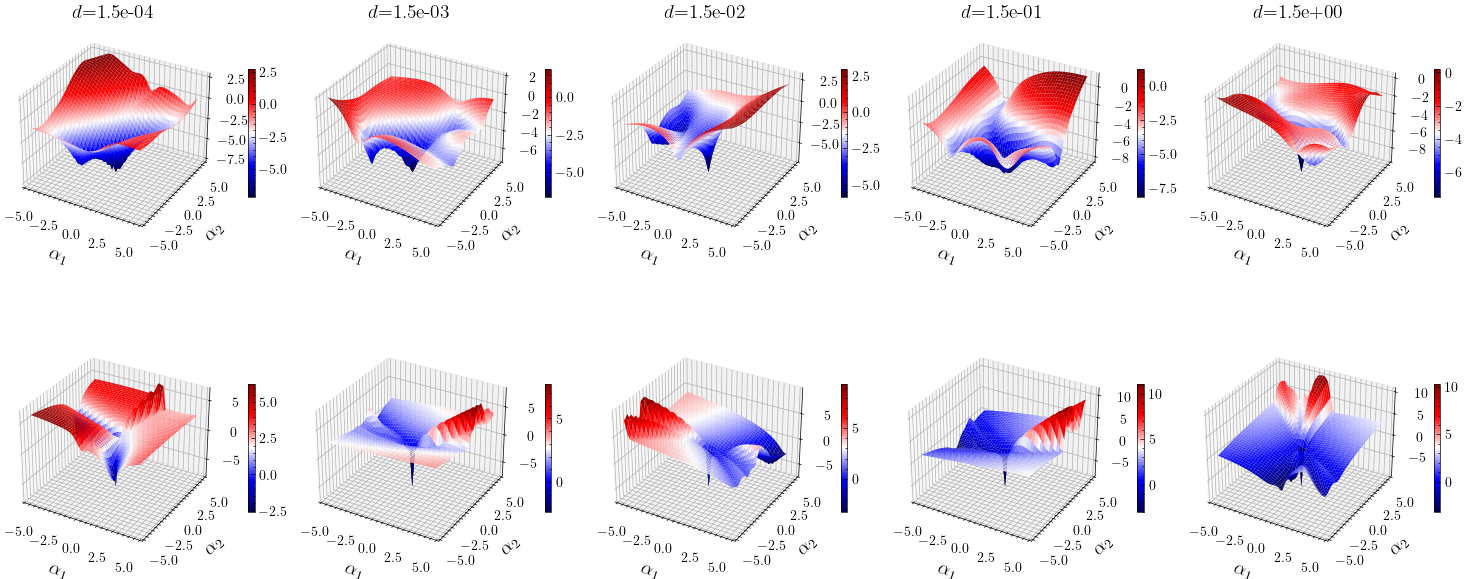

In [13]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[1, idx].set_zlim(vmin, vmax)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

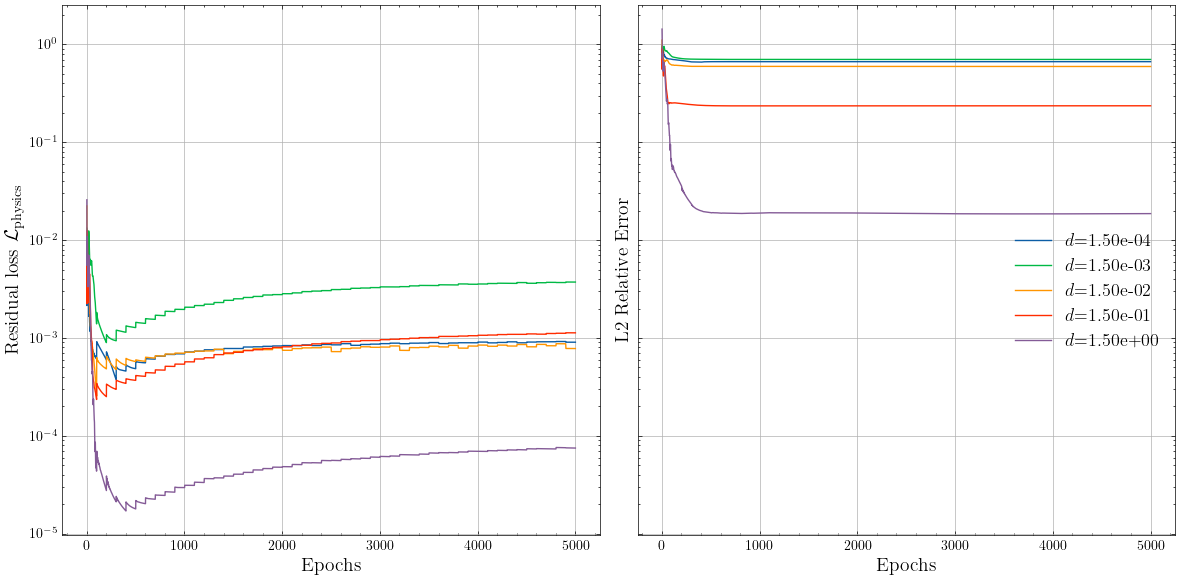

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the random direction vector subspace projection of the loss landscape
for residual_loss, param, l2_relative in zip(residual_losses_per_param, PARAM_LIST, test_losses_per_param_per_epoch):
    
    ax[0].semilogy(range(1, EPOCHS+1), residual_loss, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel(r"Residual loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[0].grid()

    ax[1].semilogy(range(1, EPOCHS+1), l2_relative, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("L2 Relative Error", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.tight_layout()

# # Output the plots as PDF to the desired directory
# loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for skewness, kurt, param in zip(skewness_per_param, kurtosis_per_param, PARAM_LIST): 
    ax[0].plot(range(1, EPOCHS+1), skewness, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Skewness", fontsize=14)
    ax[0].grid()

    ax[1].plot(range(1, EPOCHS+1), kurt, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Kurtosis", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.plot()

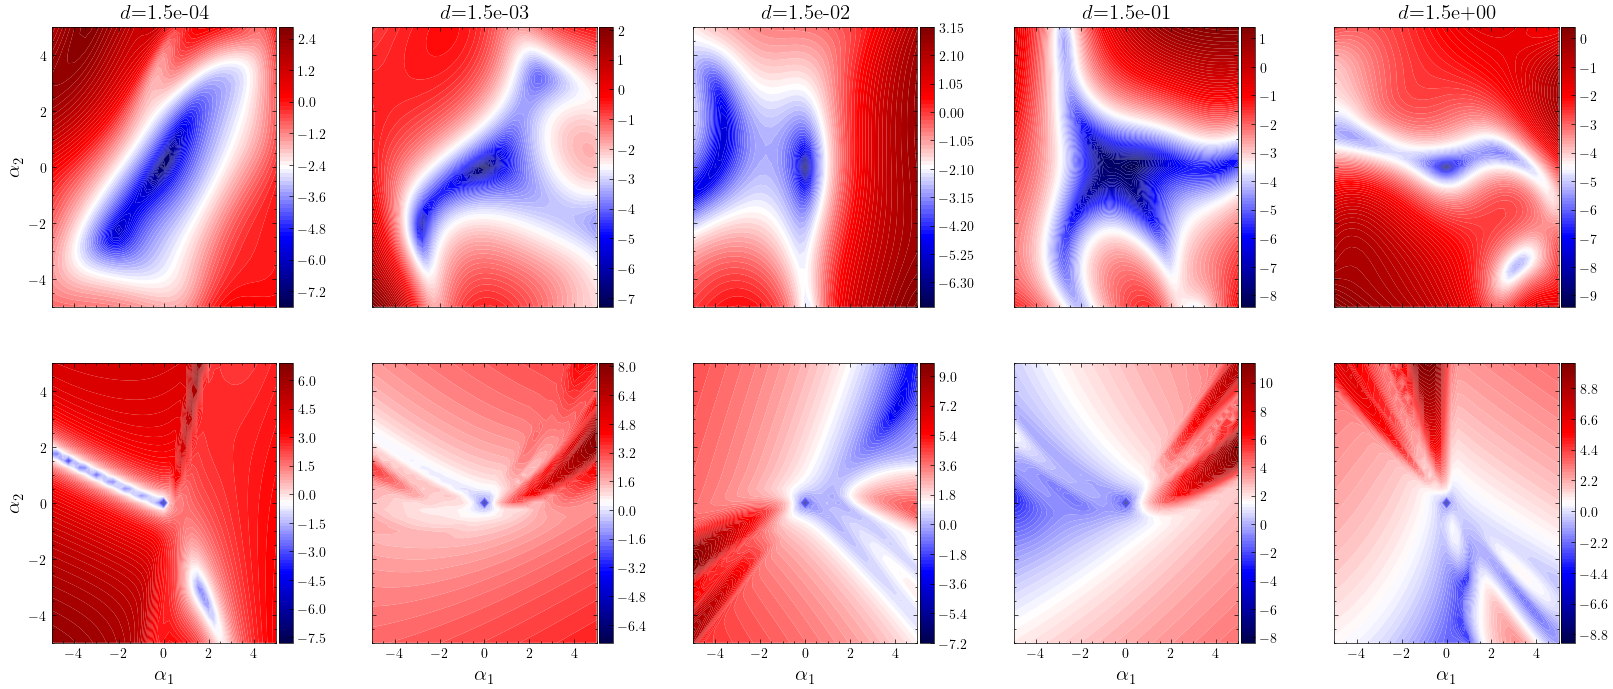

In [15]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.01)

    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=15)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.01)
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_5334/450371585.py:46: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_5334/450371585.py:47: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 5.29e+00
L2 relative error: 6.67e-01
L2 absolute error: 5.49e+00
L2 relative error: 7.03e-01
L2 absolute error: 3.84e+00
L2 relative error: 5.96e-01
L2 absolute error: 7.65e-01
L2 relative error: 2.36e-01
L2 absolute error: 1.54e-02
L2 relative error: 1.87e-02


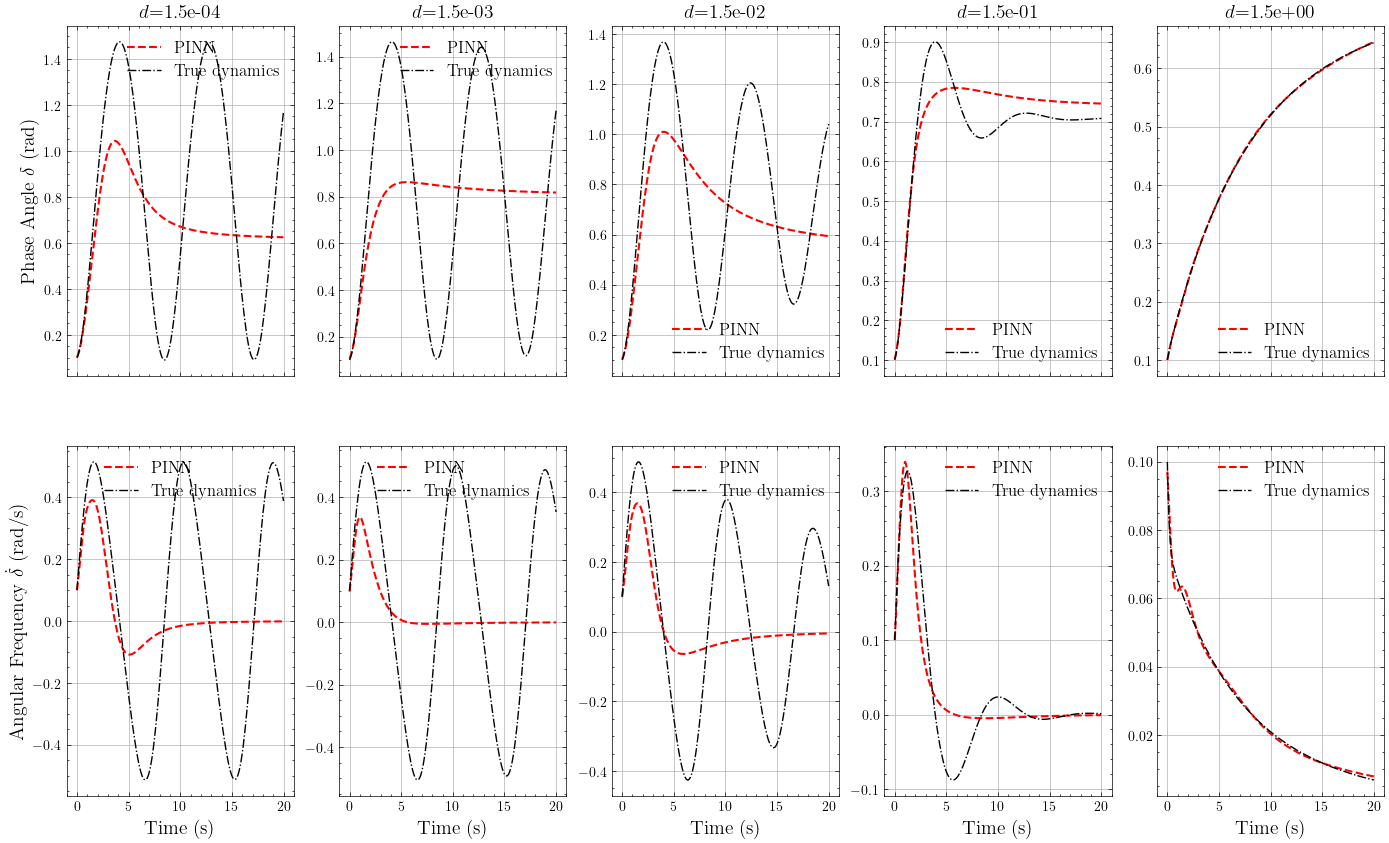

In [16]:
abs_errors_pinns = []
rel_errors_pinns = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]

    angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    phase_angle_pred = pinn_models[index].forward(data=times_tensor, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times_tensor,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0).squeeze()
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)

    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_labels, color="black", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_labels, color="black", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"pinn/{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
dense_domain_set = LHC.random(n=N_C*10)
dense_domain_set = qmc.scale(
    dense_domain_set, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

dense_domain_set: torch.tensor = torch.tensor(
    data=dense_domain_set[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)


fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    residual_loss = []

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    for collocation_point in dense_domain_set:

        pinn = pinn_models[idx]

        phase_angle_pred = pinn.forward(data=collocation_point)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False)
        residual_loss.append(residual.item())

    skewness_val = skew(a=np.array(residual_loss))
    kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

    print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[0, idx].semilogy(dense_domain_set.detach().numpy(), residual_loss, 'o', marker='.')
    axes[0, idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[0, idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
        axes[1, idx].set_ylabel("Frequency")

    axes[1, idx].hist(residual_loss, log=False)
    axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    test_performance = []

    for time_idx, time in enumerate(times_tensor):
        
        pinn = pinn_models[idx]

        ground_truth_phase_angle = numerical_solutions_exact_tensor[idx, 0, time_idx].view(1)

        phase_angle_pred = pinn.forward(data=time)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=time,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        _, l2_rel = l2_error(pred=phase_angle_pred, ground_truth=ground_truth_phase_angle, dim=0)
        test_performance.append(l2_rel.item())

    print(type(numerical_domain))
    axes[idx].semilogy(numerical_domain, test_performance, 'o')
    axes[idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[idx].set_ylabel(r"$L_2$ relative error")

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+test_error, format="pdf", bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, training_loss) in zip(PARAM_LIST, training_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)
ax.set_xlabel("Epochs", fontsize=12)
ax.grid()
ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1.25, 0.6), borderaxespad=0.)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()